In [1]:
import pandas as pd
import numpy as np
from numpy import array
from skimage.io import imshow
from sklearn import metrics as mt
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from keras.layers import Reshape
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
import seaborn as sns
from keras.models import load_model
import random
import h5py

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#Example of cade to load the data generated from hdf5
hdf5_f = h5py.File("./Data/characters_all_64x64.hdf5", mode='r')

X = hdf5_f["X_train_aug"]
y = hdf5_f["y_train_aug"]
# print(X.shape, y.shape)
X_train = np.copy(X)
y_train = np.copy(y)

X = hdf5_f["X_test_aug"]
y = hdf5_f["y_test_aug"]
# print(X.shape, y.shape)
X_test = np.copy(X)
y_test = np.copy(y)

hdf5_f.close()

In [3]:
X_train = X_train[:2500]
y_train = y_train[:2500]

X_test = X_test[:2500]
y_test = y_test[:2500]

Flip close brackets to produce open brackets

In [4]:
# find close brackets
close_bracket_indices = list(np.where(y_train == ord(']'))[0])

# take random sample
random.shuffle(close_bracket_indices)
close_bracket_indices = close_bracket_indices[:int(len(close_bracket_indices)/2)]

for i in close_bracket_indices:
    X_train[i] = np.fliplr(X_train[i])
    y_train[i] = ord('[')
    
    
# find close brackets
close_bracket_indices = list(np.where(y_test == ord(']'))[0])

# take random sample
random.shuffle(close_bracket_indices)
close_bracket_indices = close_bracket_indices[:int(len(close_bracket_indices)/2)]

for i in close_bracket_indices:
    X_test[i] = np.fliplr(X_train[i])
    y_test[i] = ord('[')    

In [5]:
one_hot = LabelBinarizer()
y_train_ohe = one_hot.fit_transform(y_train)
y_test_ohe = one_hot.fit_transform(y_test)
y_train_ohe.shape

(2500, 89)

In [6]:
classes = [chr(x) for x in sorted(set(y_test))]

In [7]:
img_wh = 64
NUM_CLASSES = len(classes)

b


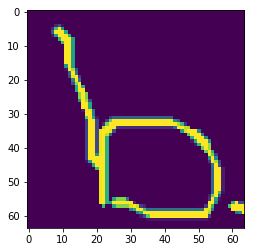

In [8]:
i=3
print(chr(y_train[i]))
plt.imshow(X_train[i,0,:,:].astype(np.float32))
plt.show()

Convert to channels last

In [9]:
X_train.shape

X_train = np.transpose(X_train, (0,2,3,1))
X_test = np.transpose(X_test, (0,2,3,1))

In [10]:
X_test.shape

(2500, 64, 64, 1)

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=5, # used, Int. Degree range for random rotations.
    width_shift_range=0.1, # used, Float (fraction of total width). Range for random horizontal shifts.
    height_shift_range=0.1, # used,  Float (fraction of total height). Range for random vertical shifts.
    shear_range=0., # Float. Shear Intensity (Shear angle in counter-clockwise direction as radians)
    zoom_range=0.,
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None,
    data_format="channels_last")

datagen.fit(X_train)

In [12]:
cnn = Sequential()
cnn.add(Conv2D(filters=32,
                input_shape = (img_wh,img_wh, 1),
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax

cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(NUM_CLASSES, activation='softmax'))

# cnn.summary()

In [22]:
# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

# the flow method yields batches of images indefinitely, with the given transformations
cnn.fit_generator(datagen.flow(X_train, y_train_ohe, batch_size=128), 
                   steps_per_epoch=int(len(X_train)/1024), # how many generators to go through per epoch
                   epochs=10,
                   validation_data=(X_test, y_test_ohe)
                  )


Epoch 1/10
2/2 [==============================] - 20s 10s/step - loss: 4.5605 - acc: 0.0000e+00 - val_loss: 4.4885 - val_acc: 0.0120
Epoch 2/10
2/2 [==============================] - 21s 11s/step - loss: 4.4828 - acc: 0.0156 - val_loss: 4.4853 - val_acc: 0.0144
Epoch 3/10
2/2 [==============================] - 20s 10s/step - loss: 4.4946 - acc: 0.0234 - val_loss: 4.4805 - val_acc: 0.0184
Epoch 4/10
2/2 [==============================] - 21s 11s/step - loss: 4.4700 - acc: 0.0117 - val_loss: 4.4665 - val_acc: 0.0292
Epoch 5/10
2/2 [==============================] - 22s 11s/step - loss: 4.4796 - acc: 0.0039 - val_loss: 4.4434 - val_acc: 0.0196
Epoch 6/10
2/2 [==============================] - 21s 10s/step - loss: 4.4397 - acc: 0.0195 - val_loss: 4.4150 - val_acc: 0.0284
Epoch 7/10
2/2 [==============================] - 21s 10s/step - loss: 4.4238 - acc: 0.0312 - val_loss: 4.3957 - val_acc: 0.0264
Epoch 8/10
2/2 [==============================] - 22s 11s/step - loss: 4.4141 - acc: 0.0352 -

In [23]:
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(70,30))
    plt.rcParams.update({'font.size': 12})
    yhat = [classes[i] for i in np.argmax(net.predict(X_test), axis=-1)]
    acc = mt.accuracy_score([chr(i) for i in y_test],yhat)
    
    cm = mt.confusion_matrix([chr(i) for i in y_test], yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
    plt.title("CNN: "+'{:.4f}'.format(acc))
    plt.savefig("confusion_matrix.jpg")
    plt.show()

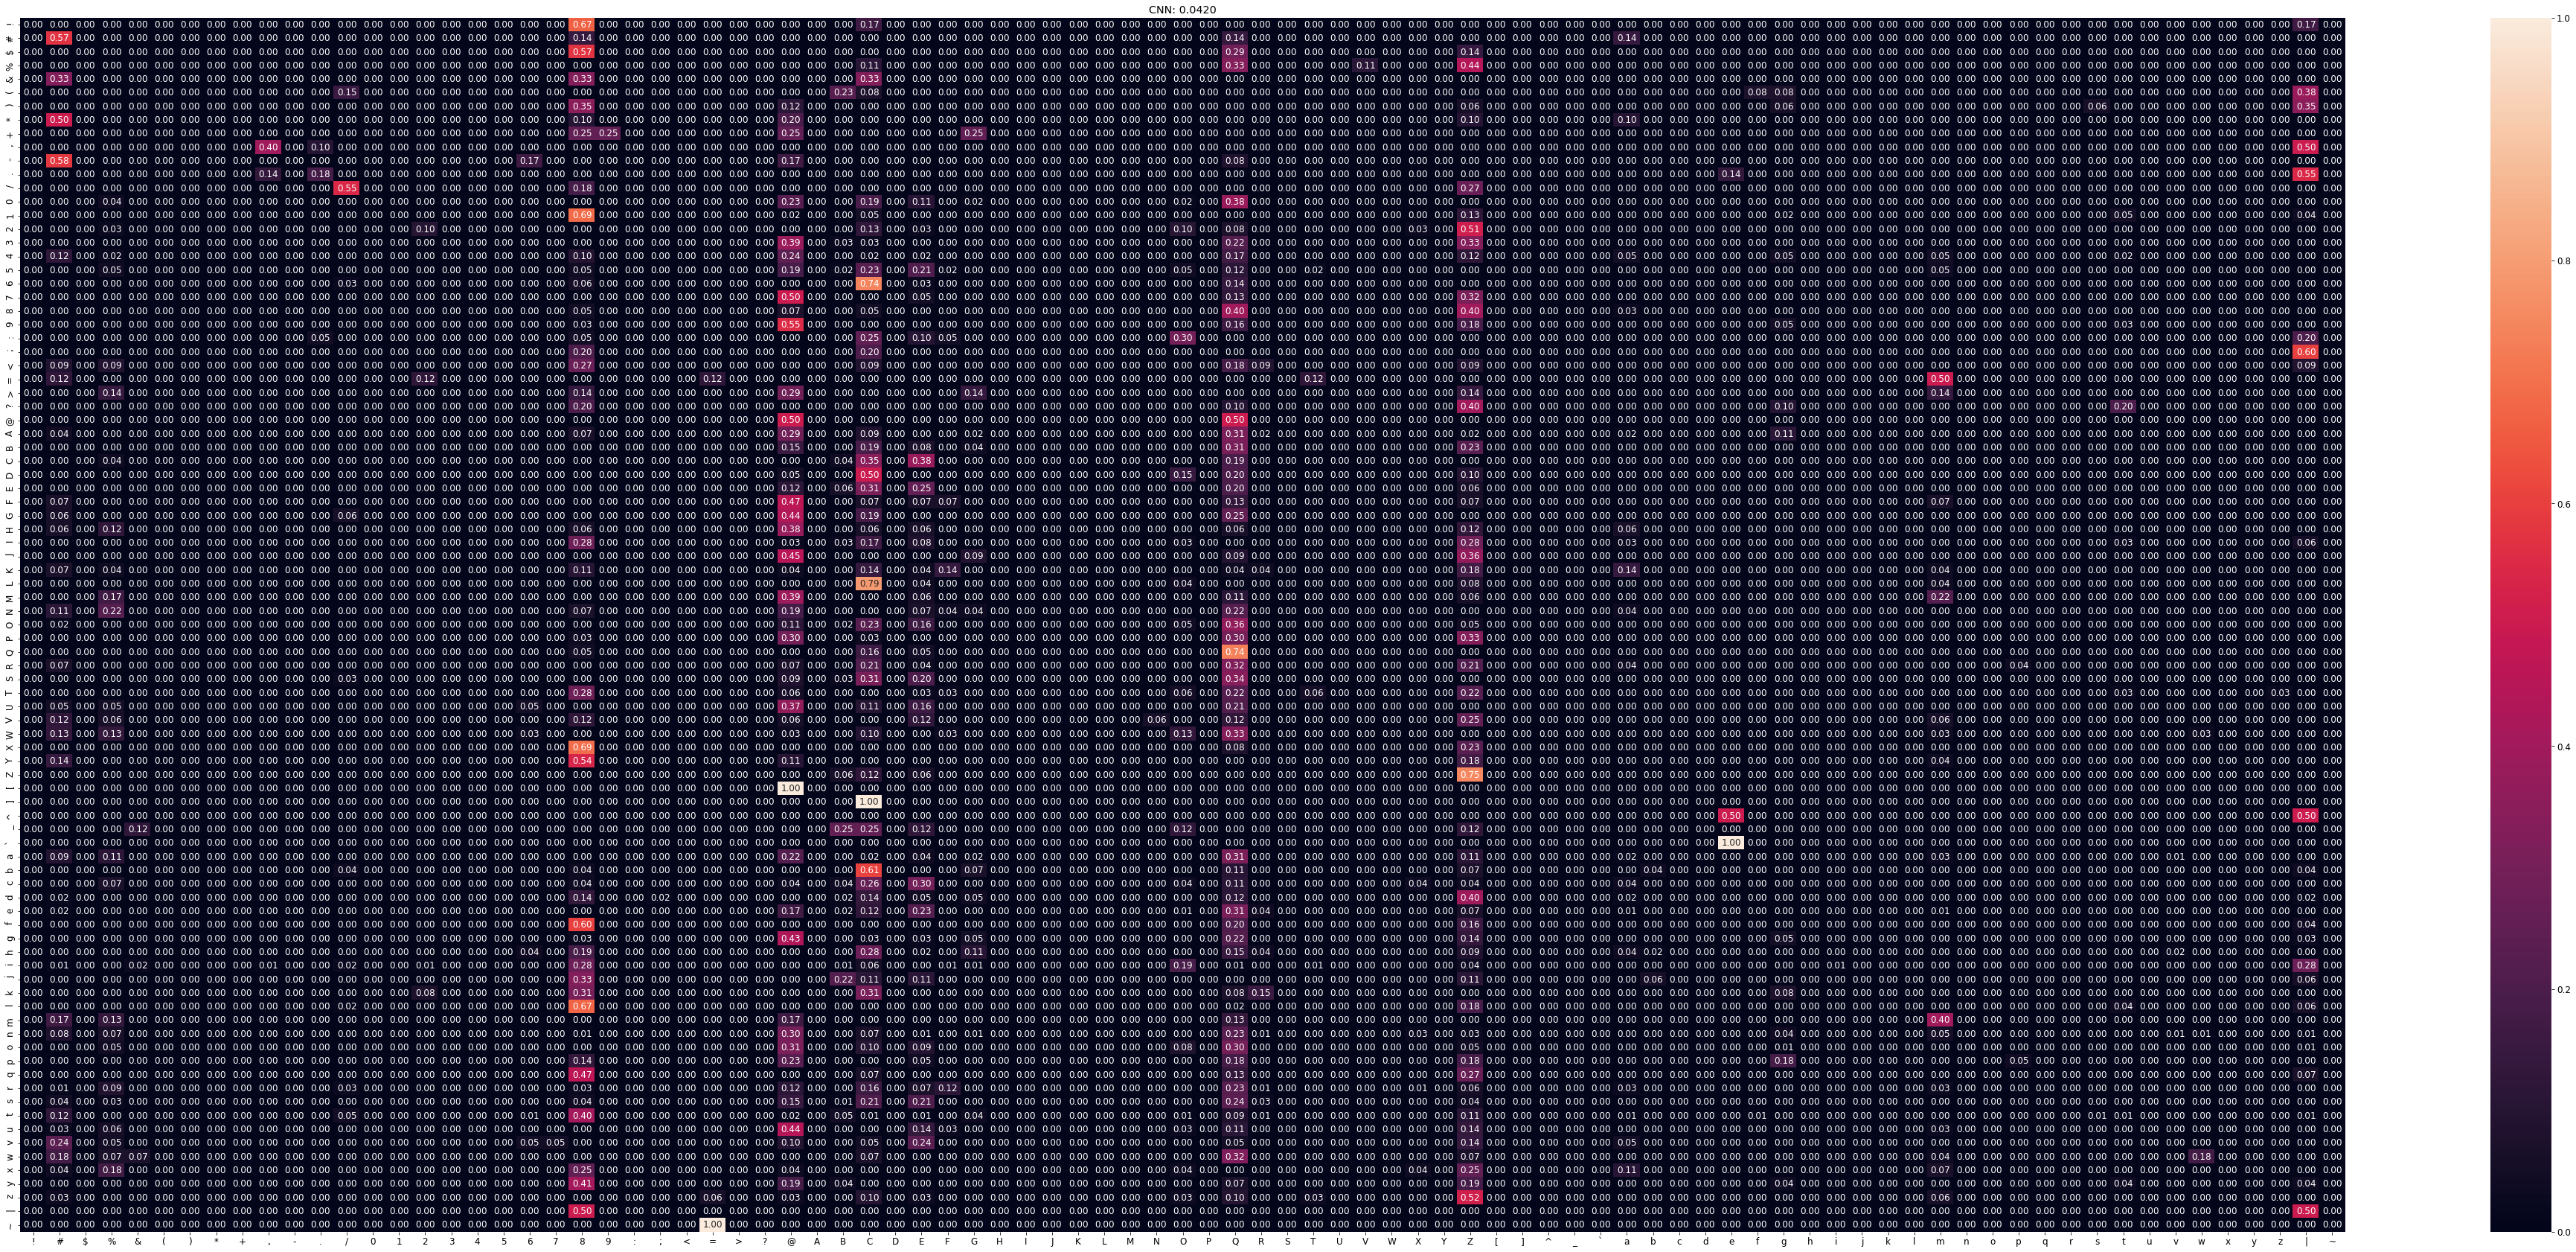

In [24]:
summarize_net(cnn, X_test, y_test, title_text='CNN:')

In [16]:
# save model to disk
cnn.save('cnn.h5')

----

_____________

Import model from disk:

In [125]:
from keras.models import load_model

model = load_model('cnn_3.h5')

/Users/ericsmith/anaconda/envs/MachineLearning/lib/python3.6/site-packages/keras/utils/conv_utils.py:93: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.copy(kernel[slices])


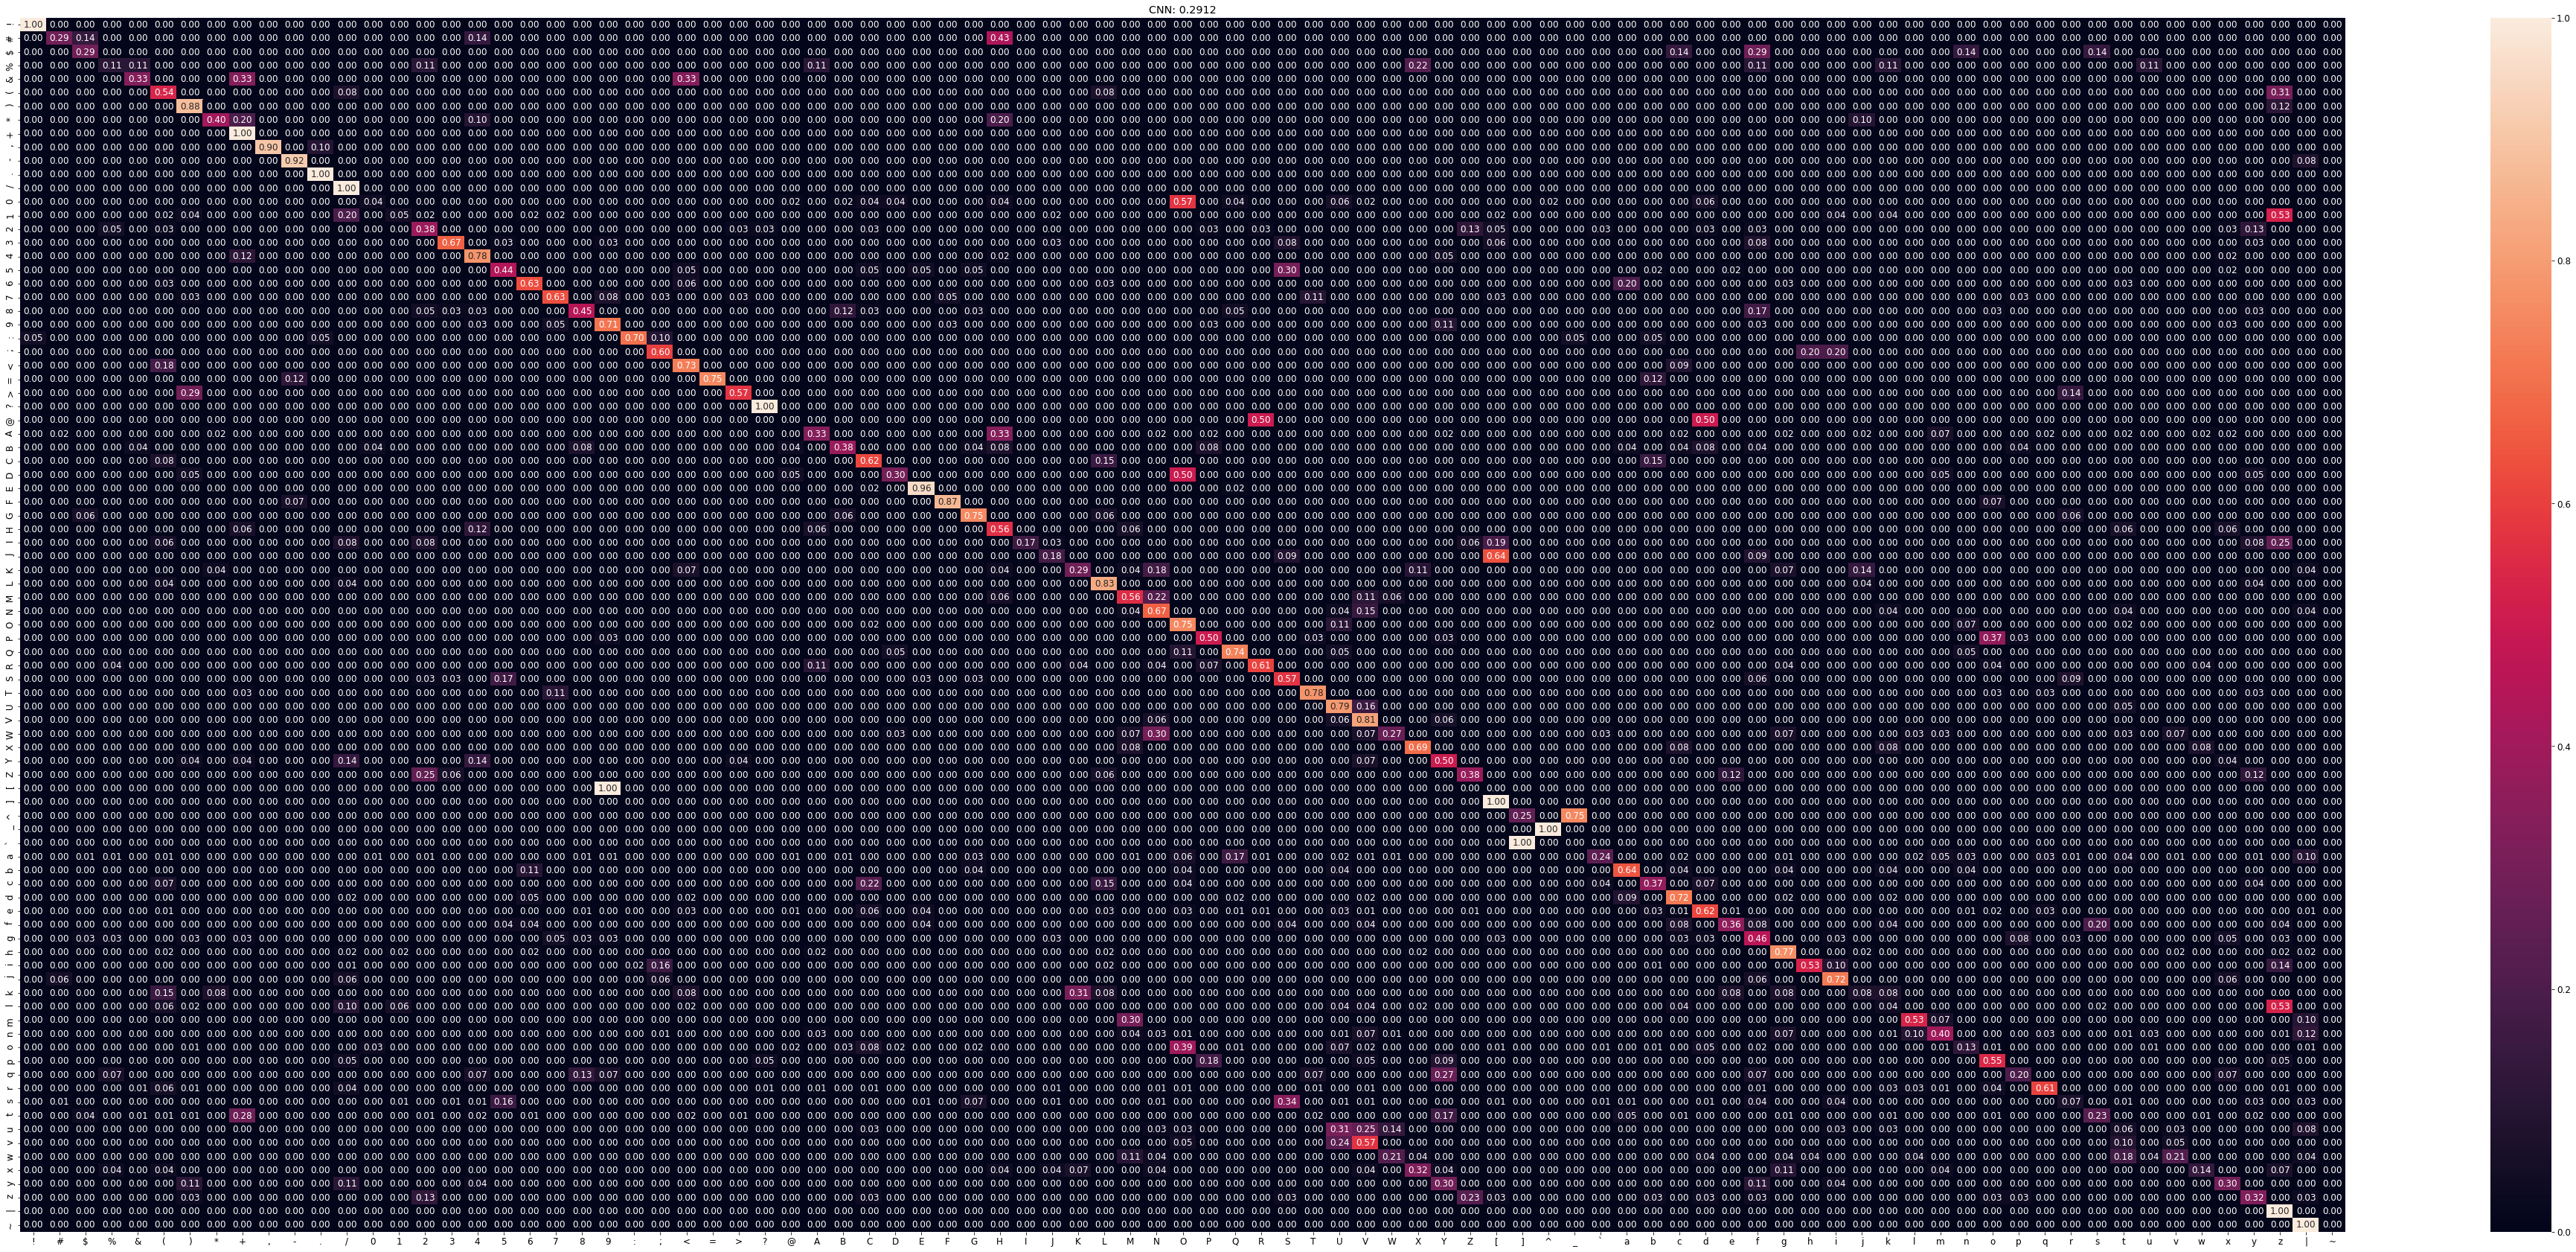

In [129]:
plt.figure(figsize=(70,30))
plt.rcParams.update({'font.size': 12})
yhat = [classes[i] for i in np.argmax(model.predict(np.transpose(X_test, (0,3,1,2))), axis=-1)]
acc = mt.accuracy_score([chr(i) for i in y_test],yhat)

cm = mt.confusion_matrix([chr(i) for i in y_test], yhat)
cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes)
plt.title("CNN: "+'{:.4f}'.format(acc))
plt.savefig("confusion_matrix.jpg")
plt.show()